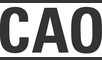

## CAO Points Analysis

***

The CAO each year publish the points required for undergraduate courses in Irish Higher Education Institutions (HEIs).  

In [1]:
# To access a URL from python
# import urllib

# Convenient HTTP requests
import requests as rq

# Regular expressions
import re

# Should always call this out on the requirements txt file as it doesn't come as standard package with python
# Only if you have anaconda does it come with the package

# Dates and times
import datetime as dt

# Data frames
import pandas as pd

# for downloading 
import urllib.request as urlrq

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current date and time
now = dt.datetime.now()

# Format as a string
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

## 2021 Points 
https://www.cao.ie/index.php?page=points&p=2021&bb=points
***

In [3]:
# Fetch the CAO points URL.
resp = rq.get('http://www2.cao.ie/points/l8.php')
# Have a quick peek (http code 200 means it is ok)
resp
# To see the whole text
# resp.text

<Response [200]>

#### Save Original data set

***

In [4]:
# Create a file path for the original data
pathhtml = 'data/cao2021_' + nowstr + '.html'

<br>

**Error on server**

Technically, the server says we should decode as per:
```
Content-Type: text/html; charset=iso-8859-1
```
However, one line uses \x96 which isn't defined in iso-8859-1.
<br>Therefore we use the similar decoding standard cp1252, which is very similar but includes #x96.

In [5]:
# The server uses the wrong encoding, fix it
original_encoding = resp.encoding
# Change to cp1252
resp.encoding = 'cp1252'

In [6]:
# Save the original html file
with open (pathhtml, 'w') as f:
    f.write(resp.text)

<br>

### Use regular expressions to select lines we want

***

In [7]:
# Compile the regular expression for matching lines
# re_course = re.compile('([A-Z]{2}[0-9]{3})  (.*)([0-9]{3})(\*?) *')
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

<br>

### Loop through the lines of the response

***

Use regular expression to extract the lines we need

In [8]:
def points_to_array(s):
    portfolio = ''
    if s[0] == '#':
        portfolio = '#'
    random = ''
    if s[-1] == '*':
        random = '*'
    points = ''
    for i in s:
        if i.isdigit():
            points = points + i
    return [points, portfolio, random]

In [9]:
# The file path for the csv file
path2021 = 'data/cao2021_csv_' + nowstr + '.csv'

In [10]:
# Keep track of how many courses we process 
no_lines = 0

# Open the cav file for writing
with open (path2021, 'w') as f:
    # Write a header row.
    f.write(','.join(['code','title','pointsR1','pointsR2']) + '\n')
    # Loop through lines of the respone
    for line in resp.iter_lines():
        # Decode the line, changed from ISO-8859-1 to cp1252
        # as one line uses \x96 which isn't defined in iso-8859-1
        dline = line.decode('cp1252')
        # Match only the lines representing courses
        if re_course.fullmatch(dline):
            # Add one to the lines counter
            no_lines = no_lines + 1
            # Uncomment next lines to see the original
            # print(line)
            # Pick out the relevant parts of the matched line
            # csv_version = re_course.sub(r'\1,\2,\3,\4', dline)
            # Print the CSV-style line
            # print(csv_version)
            # Split the line on two or more spaces
            # linesplit = re.split('  +', dline)
            # print(linesplit)
            # print(','.join(linesplit))
            # Rejoin the substrings with commas between them
            # Debug
            # print(len(linesplit), linesplit, dline)
            # The course code
            course_code = dline[:5]
            # print(course_code)
            # The course title
            course_title = dline[7:57].strip()
            # print(f"'{course_title}'")
            # Round one points
            course_points = re.split(' +', dline[60:])
            if len(course_points) !=2:
                # print(f"'{course_code} {course_points}'")
                course_points = course_points[:2]
            # Join the fields using a comma
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


<br>

**NB:** It was verified as of 24th Nov 2021 that there was 949 courses exactly in the CAO 2021 point list

In [11]:
df2021 = pd.read_csv(path2021, encoding='cp1252')

In [12]:
list(df2021.columns)

['code', 'title', 'pointsR1', 'pointsR2']

In [13]:
df2021

,code,title,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


In [14]:
df2021.dtypes

code        object
title       object
pointsR1    object
pointsR2    object
dtype: object

In [15]:
list(df2021.columns)

['code', 'title', 'pointsR1', 'pointsR2']

In [16]:
df2021.dtypes

code        object
title       object
pointsR1    object
pointsR2    object
dtype: object

In [17]:
df2021

,code,title,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


In [18]:
# # https://www.geeksforgeeks.org/python-pandas-dataframe-replace/
# remove * & # characters
df2021 = df2021.replace('[*,#]', '', regex = True)

In [19]:
# remove *, # & AQA characters
df2021 = df2021.replace('AQA', '', regex = True)

In [20]:
list(df2021.columns)

['code', 'title', 'pointsR1', 'pointsR2']

In [21]:
# remove AQA characters
# df2021.pointsR1.str.replace("AQA/", "")

In [22]:
#df2021 = df2021.replace(to_replace ="AQA",value ='NAN')

In [23]:
display(df2021.iloc[842])

code                                                    MH801
title       Early Childhood - Teaching and Learning (part-...
pointsR1                                                     
pointsR2                                                     
Name: 842, dtype: object

In [24]:
# https://stackoverflow.com/questions/8420143/valueerror-could-not-convert-string-to-float-id
# Replace empty spaces
# df2021 = df2021.replace(r'^\s*$', np.nan, regex=True)

In [25]:
# dict_columns_type = {'pointsR1': float, 'pointsR2': float}
# df2021 = df2021.astype(dict_columns_type)

In [26]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
df2021[['pointsR1','pointsR2']]= df2021[['pointsR1','pointsR2']].apply(pd.to_numeric)

In [27]:
print (df2021)

      code                                              title  pointsR1  \
0    AL801     Software Design for Virtual Reality and Gaming     300.0   
1    AL802  Software Design in Artificial Intelligence for...     313.0   
2    AL803  Software Design for Mobile Apps and Connected ...     350.0   
3    AL805    Computer Engineering for Network Infrastructure     321.0   
4    AL810                                 Quantity Surveying     328.0   
..     ...                                                ...       ...   
944  WD211                                 Creative Computing     270.0   
945  WD212                    Recreation and Sport Management     262.0   
946  WD230           Mechanical and Manufacturing Engineering     230.0   
947  WD231                 Early Childhood Care and Education     266.0   
948  WD232                       Business Information Systems     261.0   

     pointsR2  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
.. 

In [28]:
df2021.dtypes

code         object
title        object
pointsR1    float64
pointsR2    float64
dtype: object

In [29]:
# Create a file path for the pandas data
path2021a = 'data/cao2021a_' + nowstr + '.csv'

In [30]:
# Save pandas data frame to disk
df2021.to_csv(path2021a) 

In [31]:
df2021.dtypes

code         object
title        object
pointsR1    float64
pointsR2    float64
dtype: object

<br>

## 2020 Points
https://www.cao.ie/index.php?page=points&p=2020&bb=points

***

In [32]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

<br>

#### Save Original File

***

In [33]:
# Create a file path for the original data
pathxlsx = 'data/cao2020_' + nowstr + '.xlsx'

In [34]:
# Save original file to disk
urlrq.urlretrieve(url2020, pathxlsx)

('data/cao2020_20211217_211916.xlsx',
 <http.client.HTTPMessage at 0x1133e1799a0>)

<br>

#### Load Spreadsheet using pandas

***

In [35]:
# Download and parse the excel spreadsheet
df2020 = pd.read_excel(url2020, skiprows=10)

In [36]:
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Spot check random row
df2020.iloc[1463]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

In [38]:
# Spot check the 4th last row
df2020.iloc[-4]

CATEGORY (i.e.ISCED description)    Information and Communication Technologies (ICTs)
COURSE TITLE                                             Software Systems Development
COURSE CODE2                                                                    WD210
R1 POINTS                                                                         279
R1 Random *                                                                       NaN
R2 POINTS                                                                         NaN
R2 Random*                                                                        NaN
EOS                                                                               279
EOS Random *                                                                      NaN
EOS Mid-point                                                                     337
LEVEL                                                                               8
HEI                                                 Wa

In [39]:
# Create a file path for the pandas data
path2020 = 'data/cao2020_' + nowstr + '.csv'

In [40]:
# Save pandas data frame to disk
df2020.to_csv(path2020) 

In [41]:
######################## testing

# Check the initial shape of the DataFrame
df2020.shape

(1464, 23)

In [42]:
######################## testing

## https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/
    
# Delete rows where case numbers are zero
# This deletion is completed by "selecting" rows where case numbers are non zero
df2020new = df2020.loc[df2020["LEVEL"] > 7]
df2020new.shape

(1027, 23)

In [43]:
list(df2020new.columns)

['CATEGORY (i.e.ISCED description)',
 'COURSE TITLE',
 'COURSE CODE2',
 'R1 POINTS',
 'R1 Random *',
 'R2 POINTS',
 'R2 Random*',
 'EOS',
 'EOS Random *',
 'EOS Mid-point',
 'LEVEL',
 'HEI',
 'Test/Interview #',
 'avp',
 'v',
 'Column1',
 'Column2',
 'Column3',
 'Column4',
 'Column5',
 'Column6',
 'Column7',
 'Column8']

In [44]:
# df2020 = df2020.replace(to_replace ="#+matric",value ='')
# df2020new.replace("+matric", "")
df2020new = df2020new.replace(to_replace ="#+matric",value ='')

In [45]:
# remove AQA characters
df2020new = df2020new.replace(to_replace ="AQA",value ='')

In [46]:
# # https://www.geeksforgeeks.org/python-pandas-dataframe-replace/
# remove *, # & AQA characters
df2020new = df2020new.replace('[*,#]', '', regex = True)

In [47]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
df2020new[['R1 POINTS','R2 POINTS']] = df2020new[['R1 POINTS','R2 POINTS']].apply(pd.to_numeric)

In [48]:
df2020new.dtypes

CATEGORY (i.e.ISCED description)     object
COURSE TITLE                         object
COURSE CODE2                         object
R1 POINTS                           float64
R1 Random *                          object
R2 POINTS                           float64
R2 Random*                           object
EOS                                  object
EOS Random *                         object
EOS Mid-point                        object
LEVEL                                 int64
HEI                                  object
Test/Interview #                     object
avp                                  object
v                                    object
Column1                             float64
Column2                             float64
Column3                             float64
Column4                             float64
Column5                             float64
Column6                             float64
Column7                             float64
Column8                         

In [49]:
# Create a file path for the pandas data
path2020a = 'data/cao2020a_' + nowstr + '.csv'

In [50]:
# Save pandas data frame to disk
df2020new.to_csv(path2020a) 

<br>

## 2019 Points 
https://www.cao.ie/index.php?page=points&p=2019&bb=points
***

##### Steps to reproduce

1. Download original pdf file.
2. Open original pdf file in Microsoft Word.
3. Save Microsoft Word's converted PDF in docx format.
4. Re-save Word document for editing.
5. Delete headers and footers.
6. Delete preamble on page 1.
7. Select all and copy.
8. Paste into Notepad ++.
9. Remove HEI name headings and paste onto each course line. 
10. Delete blank lines.
11. Replace double tab characters with a single. 
12. Deleted tab character at end of line 308. 
13. Change backticks to apostrophes.

In [51]:
df2019 = pd.read_csv('data/cao2019_20211109_edited.csv', header=0, sep='\t')

In [52]:
# delimiter=';'
# df2019 = pd.read_csv('data/cao2019_20211109_edited.csv', sep='\t')

In [53]:
df2019

,HEI,Course Code,INSTITUTION and COURSE,EOS,Mid
0,Athlone Institute of Technology,AL801,Software Design with Virtual Reality and Gaming,304,328.0
1,Athlone Institute of Technology,AL802,Software Design with Cloud Computing,301,306.0
2,Athlone Institute of Technology,AL803,Software Design with Mobile Apps and Connected...,309,337.0
3,Athlone Institute of Technology,AL805,Network Management and Cloud Infrastructure,329,442.0
4,Athlone Institute of Technology,AL810,Quantity Surveying,307,349.0
...,...,...,...,...,...
925,Waterford Institute of Technology,WD200,Arts (options),221,296.0
926,Waterford Institute of Technology,WD210,Software Systems Development,271,329.0
927,Waterford Institute of Technology,WD211,Creative Computing,275,322.0
928,Waterford Institute of Technology,WD212,Recreation and Sport Management,274,311.0


In [54]:
# Create a file path for the pandas data
path2019 = 'data/cao2019_' + nowstr + '.csv'

In [55]:
# Save pandas data frame to disk
df2019.to_csv(path2019) 

In [56]:
# remove *, # & AQA characters
# df2019 = df2019.replace('[+mat]', '')
df2019 = df2019.replace(to_replace ="\+mat",value = '0', regex = True)

In [57]:
# # https://www.geeksforgeeks.org/python-pandas-dataframe-replace/
# remove *, # & AQA characters
df2019 = df2019.replace('[*,#]', '', regex = True)

In [58]:
# Create a file path for the pandas data
path2019a = 'data/cao2019a_' + nowstr + '.csv'

In [59]:
# Save pandas data frame to disk
df2019.to_csv(path2019a) 

In [60]:
df2019.dtypes

HEI                        object
Course Code                object
INSTITUTION and COURSE     object
EOS                        object
Mid                       float64
dtype: object

In [61]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
df2019[['EOS','Mid']] = df2019[['EOS','Mid']].apply(pd.to_numeric)
# df2019[['Mid']] = df2019[['Mid']].apply(pd.to_numeric)

In [62]:
df2019.dtypes

HEI                        object
Course Code                object
INSTITUTION and COURSE     object
EOS                       float64
Mid                       float64
dtype: object

<br>

##  Concat and join

Now that we have extract the data by year, we will need to concatenate and join the data together before we can begin analysis. 

In [63]:
courses2021 = df2021[['code', 'title']]
courses2021

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [64]:
courses2020 = df2020new[['COURSE CODE2', 'COURSE TITLE']]
courses2020.columns = ['code', 'title']
courses2020

,code,title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,First Year Art & Design (Common Entryportfolio)
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1455,WD200,Arts (options)
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


In [65]:
courses2019 = df2019[['Course Code', 'INSTITUTION and COURSE']]
courses2019.columns = ['code', 'title']
courses2019

,code,title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


In [66]:
allcourses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
2901,WD200,Arts (options)
2902,WD210,Software Systems Development
2903,WD211,Creative Computing
2904,WD212,Recreation and Sport Management


In [67]:
allcourses.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2901     True
2902     True
2903     True
2904     True
2905     True
Length: 2906, dtype: bool

In [68]:
allcourses.sort_values('code')

,code,title
175,AC120,International Business
2144,AC120,International Business
949,AC120,International Business
176,AC137,Liberal Arts
2145,AC137,Liberal Arts
...,...,...
1975,WD230,Mechanical and Manufacturing Engineering
946,WD230,Mechanical and Manufacturing Engineering
2905,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [69]:
################ testing

dfallcourses = allcourses

In [70]:
################## testing

# Create a file path for the pandas data
pathallcourses = 'data/allcourses_' + nowstr + '.csv'

In [71]:
################## testing

# Save pandas data frame to disk
dfallcourses.to_csv(pathallcourses) 

In [72]:
allcourses.loc[175], allcourses.loc[949]

(code                      AC120
 title    International Business
 Name: 175, dtype: object,
 code                      AC120
 title    International Business
 Name: 949, dtype: object)

In [73]:
# Finds all extra copies of duplicated rows
allcourses[allcourses.duplicated()]

,code,title
949,AC120,International Business
950,AC137,Liberal Arts
952,AD102,Graphic Design and Moving Image Design (portfo...
955,AD204,Fine Art (portfolio)
956,AD211,Fashion Design (portfolio)
...,...,...
2901,WD200,Arts (options)
2902,WD210,Software Systems Development
2903,WD211,Creative Computing
2904,WD212,Recreation and Sport Management


In [74]:
# Returns a copy of the data frame with the duplicates removed
allcourses.drop_duplicates()

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
2844,TL801,Animation Visual Effects and Motion Design
2845,TL802,TV Radio and New Media
2846,TL803,Music Technology
2849,TL812,Computing with Digital Media


In [75]:
# duplicates on the course code
allcourses[allcourses.duplicated(subset=['code'])]

,code,title
949,AC120,International Business
950,AC137,Liberal Arts
951,AD101,First Year Art & Design (Common Entryportfolio)
952,AD102,Graphic Design and Moving Image Design (portfo...
953,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
2901,WD200,Arts (options)
2902,WD210,Software Systems Development
2903,WD211,Creative Computing
2904,WD212,Recreation and Sport Management


In [76]:
# Returns a copy of the data frame with the duplicates removed - based only on code
allcourses.drop_duplicates(subset=['code'], inplace=True, ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
1209,SG441,Environmental Science
1210,SG446,Applied Archaeology
1211,TL803,Music Technology
1212,TL812,Computing with Digital Media


<br>

### Join to the points

***

In [77]:
# Set the index to the code column
df2021.set_index('code', inplace=True)
df2021.columns = ['title', 'points_r1_2021', 'points_r2_2021']
df2021

,title,points_r1_2021,points_r2_2021
code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN
AL802,Software Design in Artificial Intelligence for...,313.0,NaN
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN
AL805,Computer Engineering for Network Infrastructure,321.0,NaN
AL810,Quantity Surveying,328.0,NaN
...,...,...,...
WD211,Creative Computing,270.0,NaN
WD212,Recreation and Sport Management,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,230.0,230.0


In [78]:
# Set the index to the code column
allcourses.set_index('code', inplace=True)
allcourses

,title
code,
AL801,Software Design for Virtual Reality and Gaming
AL802,Software Design in Artificial Intelligence for...
AL803,Software Design for Mobile Apps and Connected ...
AL805,Computer Engineering for Network Infrastructure
AL810,Quantity Surveying
...,...
SG441,Environmental Science
SG446,Applied Archaeology
TL803,Music Technology


In [79]:
allcourses = allcourses.join(df2021[['points_r1_2021']])
allcourses

,title,points_r1_2021
code,,
AL801,Software Design for Virtual Reality and Gaming,300.0
AL802,Software Design in Artificial Intelligence for...,313.0
AL803,Software Design for Mobile Apps and Connected ...,350.0
AL805,Computer Engineering for Network Infrastructure,321.0
AL810,Quantity Surveying,328.0
...,...,...
SG441,Environmental Science,NaN
SG446,Applied Archaeology,NaN
TL803,Music Technology,NaN


In [80]:
df2020_r1 = df2020new[['COURSE CODE2', 'R1 POINTS']]
df2020_r1.columns = ['code', 'points_r1_2020']
df2020_r1

,code,points_r1_2020
0,AC120,209.0
1,AC137,252.0
2,AD101,NaN
3,AD102,NaN
4,AD103,NaN
...,...,...
1455,WD200,NaN
1460,WD210,279.0
1461,WD211,271.0
1462,WD212,270.0


In [81]:
# Set the index to the code column
df2020_r1.set_index('code', inplace=True)
df2020_r1

,points_r1_2020
code,
AC120,209.0
AC137,252.0
AD101,NaN
AD102,NaN
AD103,NaN
...,...
WD200,NaN
WD210,279.0
WD211,271.0


In [82]:
# Join 2020 points to allcourses
allcourses = allcourses.join(df2020_r1)
allcourses

,title,points_r1_2021,points_r1_2020
code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0
AL810,Quantity Surveying,328.0,319.0
...,...,...,...
SG441,Environmental Science,NaN,NaN
SG446,Applied Archaeology,NaN,NaN
TL803,Music Technology,NaN,NaN


In [83]:
df2019_r1 = df2019[['Course Code', 'EOS']]
df2019_r1.columns = ['code', 'points_r1_2019']
df2019_r1

,code,points_r1_2019
0,AL801,304.0
1,AL802,301.0
2,AL803,309.0
3,AL805,329.0
4,AL810,307.0
...,...,...
925,WD200,221.0
926,WD210,271.0
927,WD211,275.0
928,WD212,274.0


In [84]:
# Set the index to the code column
df2019_r1.set_index('code', inplace=True)
df2019_r1

,points_r1_2019
code,
AL801,304.0
AL802,301.0
AL803,309.0
AL805,329.0
AL810,307.0
...,...
WD200,221.0
WD210,271.0
WD211,275.0


In [85]:
# Join 2019 points to allcourses
allcourses = allcourses.join(df2019_r1)
allcourses

,title,points_r1_2021,points_r1_2020,points_r1_2019
code,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0
AL810,Quantity Surveying,328.0,319.0,307.0
...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0
SG446,Applied Archaeology,NaN,NaN,289.0
TL803,Music Technology,NaN,NaN,264.0


In [86]:
# dfround1.dtypes

In [87]:
################ testing

dfround1 = allcourses

In [88]:
################## testing

# Create a file path for the pandas data
# pathround1 = 'data/round1_' + nowstr + '.csv'

In [89]:
################## testing

# Save pandas data frame to disk
# dfround1.to_csv(pathround1) 

In [90]:
# https://www.geeksforgeeks.org/python-pandas-dataframe-replace/
# dfround1a = dfround1.replace('[*,#]', '', regex = True)

In [91]:
# pathround1 = 'data/round1a_' + nowstr + '.csv'
# dfround1a.to_csv(pathround1) 

In [92]:
# https://www.statology.org/create-column-based-on-condition-pandas/

#create new column titled 'Change 21 vs 20'
dfround1['Change 21 vs 20'] = np.where(dfround1['points_r1_2021']>dfround1['points_r1_2021'], 'Points increase', 'Points decrease')

#view DataFrame 
dfround1

,title,points_r1_2021,points_r1_2020,points_r1_2019,Change 21 vs 20
code,,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0,Points decrease
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0,Points decrease
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0,Points decrease
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0,Points decrease
AL810,Quantity Surveying,328.0,319.0,307.0,Points decrease
...,...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0,Points decrease
SG446,Applied Archaeology,NaN,NaN,289.0,Points decrease
TL803,Music Technology,NaN,NaN,264.0,Points decrease


In [93]:
# dfround1a['change1'] = (dfround1a[{str(int(startamt)}]) - (dfround1a['points_r1_2021'])

In [94]:
# dfround1a['change1'] = (dfround1a['points_r1_2021'].astype(int)) - (dfround1a['points_r1_2021'].astype(int))

In [95]:
dfround1['21vs20'] = dfround1['points_r1_2021']-dfround1['points_r1_2020']
dfround1['21vs19'] = dfround1['points_r1_2021']-dfround1['points_r1_2019']
dfround1['20vs19'] = dfround1['points_r1_2020']-dfround1['points_r1_2019']

#view DataFrame 
dfround1

,title,points_r1_2021,points_r1_2020,points_r1_2019,Change 21 vs 20,21vs20,21vs19,20vs19
code,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0,Points decrease,-3.0,-4.0,-1.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0,Points decrease,-19.0,12.0,31.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0,Points decrease,13.0,41.0,28.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0,Points decrease,-12.0,-8.0,4.0
AL810,Quantity Surveying,328.0,319.0,307.0,Points decrease,9.0,21.0,12.0
...,...,...,...,...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0,Points decrease,NaN,NaN,NaN
SG446,Applied Archaeology,NaN,NaN,289.0,Points decrease,NaN,NaN,NaN
TL803,Music Technology,NaN,NaN,264.0,Points decrease,NaN,NaN,NaN


In [96]:
dfround1 = dfround1.replace(r'\D', "", regex=True)

In [97]:
print(dfround1[0:10])

      title  points_r1_2021  points_r1_2020  points_r1_2019 Change 21 vs 20  \
code                                                                          
AL801                 300.0           303.0           304.0                   
AL802                 313.0           332.0           301.0                   
AL803                 350.0           337.0           309.0                   
AL805                 321.0           333.0           329.0                   
AL810                 328.0           319.0           307.0                   
AL811                   NaN           320.0             NaN                   
AL820                 327.0           308.0           300.0                   
AL830                 451.0           442.0           410.0                   
AL832                 440.0           387.0           387.0                   
AL835                 356.0             NaN             NaN                   

       21vs20  21vs19  20vs19  
code               

In [98]:
#https://www.kite.com/python/answers/how-to-convert-a-pandas-dataframe-column-containing-nans-to-a-specific-type-in-python
# Convert NaNs to Integer 

dfround1['21vs20'].astype("Int64")

code
AL801      -3
AL802     -19
AL803      13
AL805     -12
AL810       9
         ... 
SG441    <NA>
SG446    <NA>
TL803    <NA>
TL812    <NA>
WD148    <NA>
Name: 21vs20, Length: 1214, dtype: Int64

In [99]:
dfround1.dtypes

title               object
points_r1_2021     float64
points_r1_2020     float64
points_r1_2019     float64
Change 21 vs 20     object
21vs20             float64
21vs19             float64
20vs19             float64
dtype: object

In [100]:
################################# RESTART HERE
#### SINCE NANS ARE NAS 
#### TRY WRITING FORMULAS FOR CHART/PLOTTING AGAIN

In [101]:
# https://www.projectpro.io/recipes/insert-new-column-based-on-condition-in-python

rating21vs20 = []
for row in dfround1['21vs20']:
    if row > 0.0 :    rating21vs20.append('Increase')
    elif row < 0.0:   rating21vs20.append('Decrease')    
    elif row == 0.0:  rating21vs20.append('No change')
    elif row == 'Na' :      rating21vs20.append('Not a course')    
    else:             rating21vs20.append('Course for 1 year only')

rating20vs19 = []
for row in dfround1['20vs19']:
    if row > 0.0 :    rating20vs19.append('Increase')
    elif row < 0.0:   rating20vs19.append('Decrease')
    elif row == 0.0:  rating20vs19.append('No change')
    else:           rating20vs19.append('Course for 1 year only')

rating21vs19 = []
for row in dfround1['21vs19']:
    if row > 0.0 :    rating21vs19.append('Increase')
    elif row < 0.0:   rating21vs19.append('Decrease')
    elif row == 0.0:  rating21vs19.append('No change')
    else:           rating21vs19.append('Course for 1 year only')


In [102]:
dfround1['rating21vs20'] = rating21vs20
dfround1['rating20vs19'] = rating20vs19
dfround1['rating21vs19'] = rating21vs19
print(dfround1) 

      title  points_r1_2021  points_r1_2020  points_r1_2019 Change 21 vs 20  \
code                                                                          
AL801                 300.0           303.0           304.0                   
AL802                 313.0           332.0           301.0                   
AL803                 350.0           337.0           309.0                   
AL805                 321.0           333.0           329.0                   
AL810                 328.0           319.0           307.0                   
...     ...             ...             ...             ...             ...   
SG441                   NaN             NaN           297.0                   
SG446                   NaN             NaN           289.0                   
TL803                   NaN             NaN           264.0                   
TL812                   NaN             NaN           369.0                   
WD148                   NaN             NaN         

In [103]:
# Create a file path for the pandas data
pathround1 = 'data/round1_' + nowstr + '.csv'
# Save pandas data frame to disk
dfround1.to_csv(pathround1)

In [104]:
dft = dfround1['rating21vs19'].value_counts()
dft

Increase                  586
Course for 1 year only    482
Decrease                  131
No change                  15
Name: rating21vs19, dtype: int64

In [105]:
rating21vs20_count = dfround1['rating21vs20'].value_counts()
rating20vs19_count = dfround1['rating20vs19'].value_counts()
rating21vs19_count = dfround1['rating21vs19'].value_counts()

<Figure size 1440x1008 with 0 Axes>

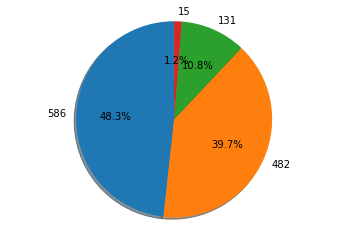

In [106]:
## https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
    
plt.figure(figsize=(20,14))
# labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(dft,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# explode=explode,
# labels=labels,
# dfround1.plot(kind='pie', y = rating21vs20_count, ax=ax1, autopct='%1.1f%%', 
# startangle=90, shadow=False, labels=dfround1['rating21vs20'], legend = False, fontsize=14)

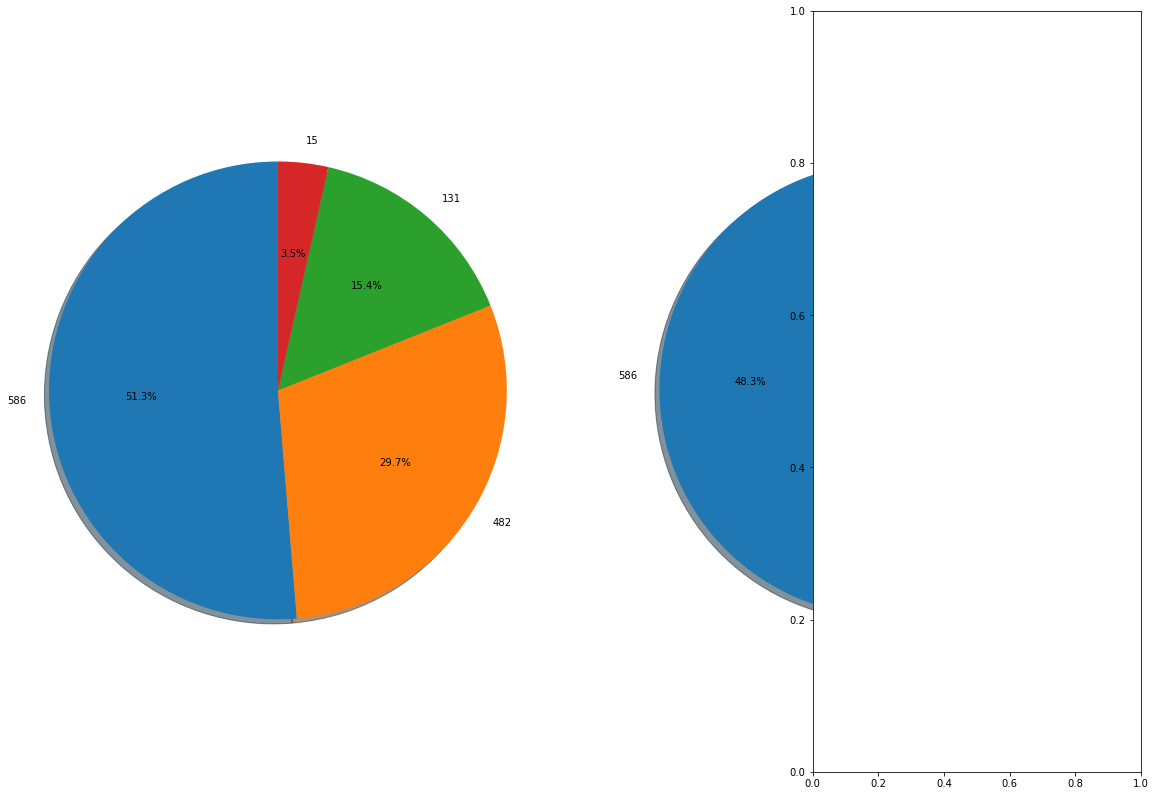

In [132]:
fig = plt.figure(figsize=(20,14))
# labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = fig.add_subplot(121)
# ax1 = plt.subplots()
ax1.pie(rating21vs20_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


ax2 = fig.add_subplot(122)
# ax2 = plt.subplots()
ax2.pie(rating21vs19_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax3 = fig.add_subplot(133)
# ax3 = plt.subplots()
# ax3.pie(rating21vs19_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
# ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

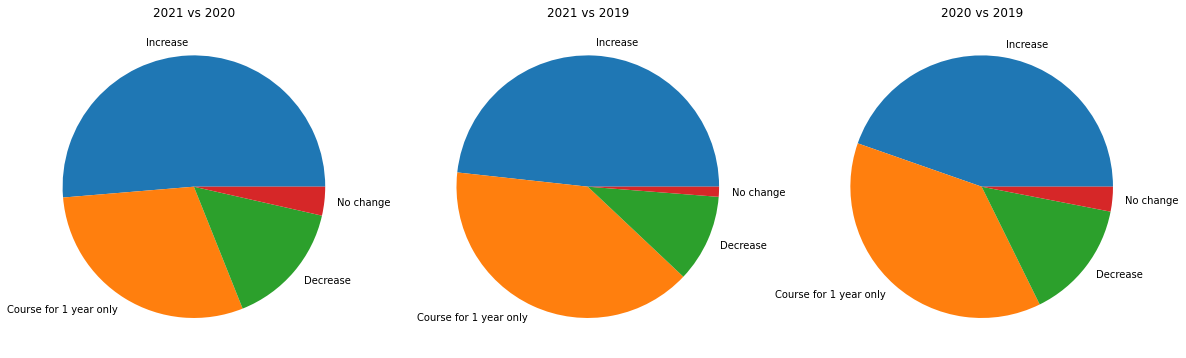

In [153]:
fig = plt.figure(figsize=(20,14))

# labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
# fig, (ax1, ax2) = plt.subplots(1, 2)

labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'

plt.subplot(1, 3, 1)
plt.title('2021 vs 2020')
plt.pie((rating21vs20_count), labels=labels)

plt.subplot(1, 3, 2)
plt.title('2021 vs 2019')
plt.pie((rating21vs19_count), labels=labels)

plt.subplot(1, 3, 3)
plt.title('2020 vs 2019')
plt.pie((rating20vs19_count), labels=labels)

plt.show()


# ax1 = fig.add_subplot(121)
# ax1 = plt.subplots()
# ax1.pie(rating21vs20_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# ax2 = fig.add_subplot(122)
# ax2 = plt.subplots()
# ax2.pie(rating21vs19_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
# ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# ax3 = fig.add_subplot(133)
# ax3 = plt.subplots()
# ax3.pie(rating21vs19_count,labels=dft, autopct='%1.1f%%', shadow=True, startangle=90)
# ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle


 ## next steps   
 
YOU CAN LOOK AT THIS OVERALL, BY COLLEGE OR BY COURSE

Do subplot that shows all 3 years of comparison on plot
 
Do the analysis by college

Do analysis on one course

Show how much the course went up or down in points
  

In [ ]:
plt.figure(figsize=(20,14))
labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'

fig1, ax1 = plt.subplots()
ax1.pie(rating20vs19_count,labels=labels, autopct='%1.1f%%', explode=[0.05]*4, shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
plt.figure(figsize=(20,14))
labels = 'Increase', 'Course for 1 year only', 'Decrease', 'No change'

fig1, ax1 = plt.subplots()
ax1.pie(rating21vs19_count,labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
data = dfround1.groupby("rating21vs19").count()
data.plot.pie(autopct="%.1f%%",subplots=True)

In [ ]:
# dfround1.plot(kind='pie', y = rating21vs20_count, ax=ax1, autopct='%1.1f%%', 
# startangle=90, shadow=False, labels=dfround1['rating21vs20'], legend = False, fontsize=14)

In [ ]:
np.where('21 vs 20' > 0, 'high', 
         (np.where('21 vs 20' < 0, 'low', 'medium')))

In [ ]:
############## testing
# https://thispointer.com/pandas-count-rows-in-a-dataframe-all-or-those-only-that-satisfy-a-condition/


seriesObj = dfround1.apply(lambda x: True if x['21 vs 20'] == 0 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)
print('Number of Rows in dataframe in which Age > 30 : ', numOfRows)

In [ ]:
# https://stackoverflow.com/questions/39109045/numpy-where-with-multiple-conditions
col = 'Change_21v20'

def conditions(x):
    if '21 vs 20' > 0:
        return "High"
    elif '21 vs 20' < 0:
        return "Medium"
    else:
        return "Low"

func = np.vectorize(conditions)
func
# Change_21v20 = func(dfround1["21 vs 20"])

# dfround1['Change_21v20'] = Change_21v20

In [ ]:
# Create a file path for the pandas data
pathround1 = 'data/round1a_' + nowstr + '.csv'
dfround1.to_csv(pathround1) 

In [ ]:
# series of counts
data1 = dfround1.value_counts("Change 21 vs 20")
# print the counts
print(data1)
plot = dfround1.plot.pie(y=str.'Change 21 vs 20', figsize=(5, 5))
plt.show()

In [ ]:
import pandas as pd

items_df = pd.DataFrame({
    'Id': [302, 504, 708, 103, 343, 565],
    'Name': ['Watch', 'Camera', 'Phone', 'Shoes', 'Laptop', 'Bed'],
    'Actual Price': [300, 400, 350, 100, 1000, 400],
    'Discount(%)': [10, 15, 5, 0, 2, 7]
})

print("Initial DataFrame:")
print(items_df, "\n")

items_df['Final Price'] = items_df['Actual Price'] - ((items_df['Discount(%)']/100) * items_df['Actual Price'])


print("DataFrame after addition of new column")
print(items_df, "\n")

items_df.dtypes

In [ ]:
def conditions(x):
    if ['21 vs 20'] > 0:
        return "Increase"
    elif ['21 vs 20'] < 0:
        return "Decrease"
    elif ['21 vs 20'] == 0:
        return "No Change"
    else:
        return "Course in 1 year only"
    
dfround1['Class'] = dfround1.apply(conditions, axis=1)

In [ ]:
df_full['class'] = np.where( ( (df_full['discount'] > 20) & (df_full['tax'] == 0 ) & (df_full['total'] > 100) & df_full['productdiscount'] ) , 1, 0)

In [ ]:
# create a list of our conditions
conditions = [
    (dfround1['21 vs 20'] > 0),
    (dfround1['21 vs 20'] < 0),
    (dfround1['21 vs 20'] == 0)
    ]


def conditions(x):
    if '21 vs 20' > 0:
        return "Increase"
    elif '21 vs 20' < 0:
        return "Decrease"
    elif '21 vs 20' == 0:
        return "No Change"
    else:
        return "Course in 1 year only"
    
# create a list of the values we want to assign for each condition
# values = ['Points increased', 'Points unchanged', 'Points decreased']

create a new column and use np.select to assign values to it using our lists as arguments
df['points'] = np.select(conditions, values)

df.head()

***
### End